In [2]:
import pandas
import gensim
import collections
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from gensim import corpora, models, similarities
from gensim.models.doc2vec import Doc2Vec, LabeledSentence  
from collections import Counter

In [3]:
def splitWord(documents):
    stoplist=set('for a of the and to in at after with'.split())  
    texts=[[word for word in document.lower().split() if word not in stoplist] for document in documents]
    return texts

def cosine(vector1, vector2):
    return float(np.dot(vector1,vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2)))

def euclidean_distance(x,y):
    return math.sqrt(sum(pow(a-b,2) for a, b in zip(x, y)))

In [78]:
def feature_extraction(stances_path, bodies_path):
    train_stance = pandas.read_csv(stances_path)
    train_bodies = pandas.read_csv(bodies_path)

    headlines = train_stance["Headline"].values
    bodies = train_bodies["articleBody"].values
    bodyids =  train_bodies["Body ID"].values
    stances = train_stance["Stance"].values

    # get the unique body id list
    body_list = list(set(bodyids))
    unique_bodies = []

    for bodyid in body_list:
        unique_bodies.append(train_bodies[train_bodies["Body ID"] == bodyid]["articleBody"].iloc[0])

    texts = splitWord(unique_bodies)
    headlines = splitWord(headlines)

    # get the total number of words in the corpus/ assume each word appear once in the body for the calculation of idf
    words_corpus = []
    for text in texts:
        text = list(set(text))
        words_corpus += text

    # get the idf list
    bodies_len = len(body_list)
    idf_list = Counter(words_corpus)
    for word in idf_list:
        idf_list[word] = math.log(bodies_len/idf_list[word])

    # get the unique word in the corpus
    corpus = list(set(words_corpus))
    # create tfidf dict for the bodies dict{body_id: body_tfidf}
    bodies_tfidf = {}
    bodies_norm = {}
    for i in range(0,len(texts)):
        tfidf_list = {};
        body_word_count = Counter(texts[i])
        word_number = len(texts[i])
        for word in body_word_count:
            tfidf_list[word] = body_word_count[word]/word_number * idf_list[word]

        bodies_tfidf[body_list[i]] = tfidf_list
        bodies_norm[body_list[i]] = np.linalg.norm(list(tfidf_list.values()))

    cos_sim_list = []
    euclidean_dist_list = []
    kl_list = []
    word_count_list = []
    for i in range(0, len(headlines)):
        headline_tfidf = {};
        headline_word_count = Counter(headlines[i])
        word_number = len(headlines[i])

        for word in headline_word_count:
            headline_tfidf[word] = headline_word_count[word]/word_number * idf_list[word]

        body_tfidf = bodies_tfidf[train_stance["Body ID"][i]]
        body_norm =  bodies_norm[train_stance["Body ID"][i]]

        cos_sim = 0
        euclidean_dist = 0
        kl = 0
        word_count = 0
        for word in headline_tfidf:
            if word in body_tfidf:
                vec1 = headline_tfidf[word]
                vec2 = body_tfidf[word]
                cos_sim += vec1*vec2
                euclidean_dist += pow((vec1 - vec2),2)
                kl += vec1 * np.log(vec1 / vec2)
                word_count += 1
            else:
                euclidean_dist += pow(headline_tfidf[word], 2)

        
        for word in body_tfidf:
            if word not in headline_tfidf:
                euclidean_dist += pow(body_tfidf[word], 2)
                
        euclidean_dist = math.sqrt(euclidean_dist)
        cos_sim /= (np.linalg.norm(list(headline_tfidf.values())) * body_norm)
        cos_sim_list.append(cos_sim)
        euclidean_dist_list.append(euclidean_dist)
        kl_list.append(kl)
        word_count_list.append(word_count)
        
    return [stances, cos_sim_list, euclidean_dist_list, kl_list, word_count_list]

In [80]:
train_result = feature_extraction('fnc-1/split/train_stances.csv', 'fnc-1/split/train_bodies.csv')

with open("fnc-1/split/train_stances_hand_features.csv","w") as csvfile:
    df = pd.DataFrame({'Stance': train_result[0], 'cos_sim': train_result[1], 'euclidean_dist': train_result[2],
                       'kl_list': train_result[3], 'word_count': train_result[4]})
    df.to_csv(csvfile)

In [81]:
validation_result = feature_extraction('fnc-1/split/validation_stances.csv', 'fnc-1/split/validation_bodies.csv')

with open("fnc-1/split/validation_stances_hand_features.csv","w") as csvfile:
    df = pd.DataFrame({'Stance': validation_result[0], 'cos_sim': validation_result[1], 'euclidean_dist': validation_result[2],
                       'kl_list': validation_result[3], 'word_count': validation_result[4]})
    df.to_csv(csvfile)

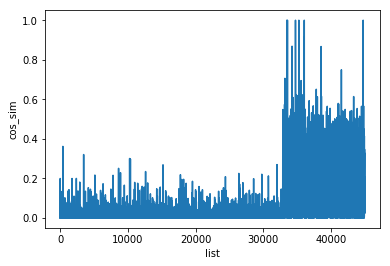

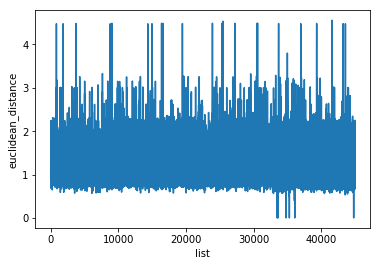

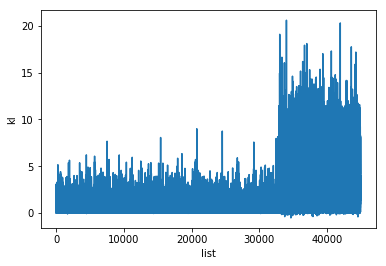

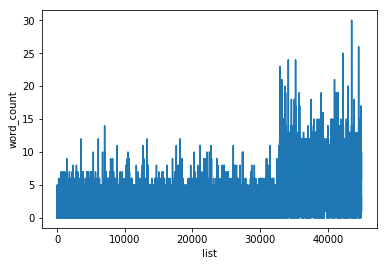

In [82]:
plt.plot(train_result[1])
plt.ylabel('cos_sim')
plt.xlabel('list')
plt.show()

plt.plot(train_result[2])
plt.ylabel('euclidean_distance')
plt.xlabel('list')
plt.show()

plt.plot(train_result[3])
plt.ylabel('kl')
plt.xlabel('list')
plt.show()

plt.plot(train_result[4])
plt.ylabel('word_count')
plt.xlabel('list')
plt.show()

In [72]:
def euclidean_distance(x,y):
    return math.sqrt(sum(pow(a-b,2) for a, b in zip(x, y)))

In [75]:
print(euclidean_distance([1,0,3,0], [1,2,0,4]))

print(math.sqrt(29))


5.385164807134504
5.385164807134504
